# Forecasting in statsmodels

This notebook describes forecasting using time series models in statsmodels.

**Note**: this notebook applies only to the state space model classes, which are:

- `sm.tsa.SARIMAX`
- `sm.tsa.UnobservedComponents`
- `sm.tsa.VARMAX`
- `sm.tsa.DynamicFactor`

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

macrodata = sm.datasets.macrodata.load_pandas().data
macrodata.index = pd.period_range('1959Q1', '2009Q3', freq='Q')

## Basic example

A simple example is to use an AR(1) model to forecast inflation. Before forecasting, let's take a look at the series:

<AxesSubplot:>

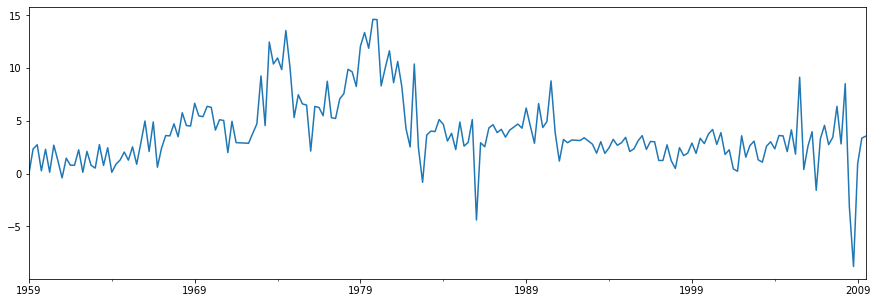

In [2]:
endog = macrodata['infl']
endog.plot(figsize=(15, 5))

### Constructing and estimating the model

The next step is to formulate the econometric model that we want to use for forecasting. In this case, we will use an AR(1) model via the `SARIMAX` class in statsmodels.

After constructing the model, we need to estimate its parameters. This is done using the `fit` method. The `summary` method produces several convenient tables showing the results.

In [3]:
# Construct the model
mod = sm.tsa.SARIMAX(endog, order=(1, 0, 0), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   infl   No. Observations:                  203
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -472.714
Date:                Tue, 02 Feb 2021   AIC                            951.427
Time:                        06:51:23   BIC                            961.367
Sample:                    03-31-1959   HQIC                           955.449
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3962      0.254      5.488      0.000       0.898       1.895
ar.L1          0.6441      0.039     16.482      0.000       0.568       0.721
sigma2         6.1519      0.397     15.487      0.0

### Forecasting

Out-of-sample forecasts are produced using the `forecast` or `get_forecast` methods from the results object.

The `forecast` method gives only point forecasts.

In [4]:
# The default is to get a one-step-ahead forecast:
print(res.forecast())

2009Q4    3.68921
Freq: Q-DEC, dtype: float64


The `get_forecast` method is more general, and also allows constructing confidence intervals.

In [5]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast()

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

infl       mean   mean_se  mean_ci_lower  mean_ci_upper
2009Q4  3.68921  2.480302      -0.390523       7.768943


The default confidence level is 95%, but this can be controlled by setting the `alpha` parameter, where the confidence level is defined as $(1 - \alpha) \times 100\%$. In the example above, we specified a confidence level of 90%, using `alpha=0.10`.

### Specifying the number of forecasts

Both of the functions `forecast` and `get_forecast` accept a single argument indicating how many forecasting steps are desired. One option for this argument is always to provide an integer describing the number of steps ahead you want.

In [6]:
print(res.forecast(steps=2))

2009Q4    3.689210
2010Q1    3.772434
Freq: Q-DEC, Name: predicted_mean, dtype: float64


In [7]:
fcast_res2 = res.get_forecast(steps=2)
# Note: since we did not specify the alpha parameter, the
# confidence level is at the default, 95%
print(fcast_res2.summary_frame())

infl        mean   mean_se  mean_ci_lower  mean_ci_upper
2009Q4  3.689210  2.480302      -1.172092       8.550512
2010Q1  3.772434  2.950274      -2.009996       9.554865


However, **if your data included a Pandas index with a defined frequency** (see the section at the end on Indexes for more information), then you can alternatively specify the date through which you want forecasts to be produced:

In [8]:
print(res.forecast('2010Q2'))

2009Q4    3.689210
2010Q1    3.772434
2010Q2    3.826039
Freq: Q-DEC, Name: predicted_mean, dtype: float64


In [9]:
fcast_res3 = res.get_forecast('2010Q2')
print(fcast_res3.summary_frame())

infl        mean   mean_se  mean_ci_lower  mean_ci_upper
2009Q4  3.689210  2.480302      -1.172092       8.550512
2010Q1  3.772434  2.950274      -2.009996       9.554865
2010Q2  3.826039  3.124571      -2.298008       9.950087


### Plotting the data, forecasts, and confidence intervals

Often it is useful to plot the data, the forecasts, and the confidence intervals. There are many ways to do this, but here's one example

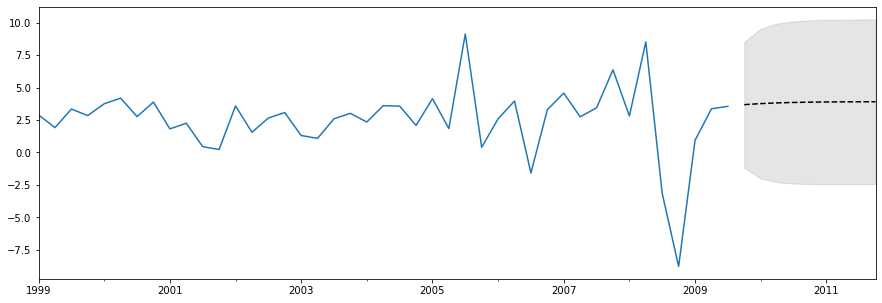

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog.loc['1999':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2011Q4').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

### Note on what to expect from forecasts

The forecast above may not look very impressive, as it is almost a straight line. This is because this is a very simple, univariate forecasting model. Nonetheless, keep in mind that these simple forecasting models can be extremely competitive.

## Prediction vs Forecasting

The results objects also contain two methods that all for both in-sample fitted values and out-of-sample forecasting. They are `predict` and `get_prediction`. The `predict` method only returns point predictions (similar to `forecast`), while the `get_prediction` method also returns additional results (similar to `get_forecast`).

In general, if your interest is out-of-sample forecasting, it is easier to stick to the `forecast` and `get_forecast` methods.

## Cross validation

**Note**: some of the functions used in this section were first introduced in statsmodels v0.11.0.

A common use case is to cross-validate forecasting methods by performing h-step-ahead forecasts recursively using the following process:

1. Fit model parameters on a training sample
2. Produce h-step-ahead forecasts from the end of that sample
3. Compare forecasts against test dataset to compute error rate
4. Expand the sample to include the next observation, and repeat

Economists sometimes call this a pseudo-out-of-sample forecast evaluation exercise, or time-series cross-validation.

### Example

We will conduct a very simple exercise of this sort using the inflation dataset above. The full dataset contains 203 observations, and for expositional purposes we'll use the first 80% as our training sample and only consider one-step-ahead forecasts.

A single iteration of the above procedure looks like the following:

In [11]:
# Step 1: fit model parameters w/ training sample
training_obs = int(len(endog) * 0.8)

training_endog = endog[:training_obs]
training_mod = sm.tsa.SARIMAX(
    training_endog, order=(1, 0, 0), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

intercept    1.162076
ar.L1        0.724242
sigma2       5.051600
dtype: float64


In [12]:
# Step 2: produce one-step-ahead forecasts
fcast = training_res.forecast()

# Step 3: compute root mean square forecasting error
true = endog.reindex(fcast.index)
error = true - fcast

# Print out the results
print(pd.concat([true.rename('true'),
                 fcast.rename('forecast'),
                 error.rename('error')], axis=1))

        true  forecast    error
1999Q3  3.35   2.55262  0.79738


To add on another observation, we can use the `append` or `extend` results methods. Either method can produce the same forecasts, but they differ in the other results that are available:

- `append` is the more complete method. It always stores results for all training observations, and it optionally allows refitting the model parameters given the new observations (note that the default is *not* to refit the parameters).
- `extend` is a faster method that may be useful if the training sample is very large. It *only* stores results for the new observations, and it does not allow refitting the model parameters (i.e. you have to use the parameters estimated on the previous sample).

If your training sample is relatively small (less than a few thousand observations, for example) or if you want to compute the best possible forecasts, then you should use the `append` method. However, if that method is infeasible (for example, because you have a very large training sample) or if you are okay with slightly suboptimal forecasts (because the parameter estimates will be slightly stale), then you can consider the `extend` method.

A second iteration, using the `append` method and refitting the parameters, would go as follows (note again that the default for `append` does not refit the parameters, but we have overridden that with the `refit=True` argument):

In [13]:
# Step 1: append a new observation to the sample and refit the parameters
append_res = training_res.append(endog[training_obs:training_obs + 1], refit=True)

# Print the re-estimated parameters
print(append_res.params)

intercept    1.171544
ar.L1        0.723152
sigma2       5.024580
dtype: float64


Notice that these estimated parameters are slightly different than those we originally estimated. With the new results object, `append_res`, we can compute forecasts starting from one observation further than the previous call:

In [14]:
# Step 2: produce one-step-ahead forecasts
fcast = append_res.forecast()

# Step 3: compute root mean square forecasting error
true = endog.reindex(fcast.index)
error = true - fcast

# Print out the results
print(pd.concat([true.rename('true'),
                 fcast.rename('forecast'),
                 error.rename('error')], axis=1))

        true  forecast     error
1999Q4  2.85  3.594102 -0.744102


Putting it altogether, we can perform the recursive forecast evaluation exercise as follows:

In [15]:
# Setup forecasts
nforecasts = 3
forecasts = {}

# Get the number of initial training observations
nobs = len(endog)
n_init_training = int(nobs * 0.8)

# Create model for initial training sample, fit parameters
init_training_endog = endog.iloc[:n_init_training]
mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='c')
res = mod.fit()

# Save initial forecast
forecasts[training_endog.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_endog = endog.iloc[t:t+1]
    res = res.append(updated_endog, refit=False)
    
    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:5, :5])

          1999Q2    1999Q3    1999Q4    2000Q1    2000Q2
1999Q3  2.552620       NaN       NaN       NaN       NaN
1999Q4  3.010790  3.588286       NaN       NaN       NaN
2000Q1  3.342616  3.760863  3.226165       NaN       NaN
2000Q2       NaN  3.885850  3.498599  3.885225       NaN
2000Q3       NaN       NaN  3.695908  3.975918  4.196649


We now have a set of three forecasts made at each point in time from 1999Q2 through 2009Q3. We can construct the forecast errors by subtracting each forecast from the actual value of `endog` at that point.

In [16]:
# Construct the forecast errors
forecast_errors = forecasts.apply(lambda column: endog - column).reindex(forecasts.index)

print(forecast_errors.iloc[:5, :5])

          1999Q2    1999Q3    1999Q4    2000Q1    2000Q2
1999Q3  0.797380       NaN       NaN       NaN       NaN
1999Q4 -0.160790 -0.738286       NaN       NaN       NaN
2000Q1  0.417384 -0.000863  0.533835       NaN       NaN
2000Q2       NaN  0.304150  0.691401  0.304775       NaN
2000Q3       NaN       NaN -0.925908 -1.205918 -1.426649


To evaluate our forecasts, we often want to look at a summary value like the root mean square error. Here we can compute that for each horizon by first flattening the forecast errors so that they are indexed by horizon and then computing the root mean square error fore each horizon.

In [17]:
# Reindex the forecasts by horizon rather than by date
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

print(flattened.iloc[:3, :5])

           1999Q2    1999Q3    1999Q4    2000Q1    2000Q2
horizon                                                  
1        0.797380 -0.738286  0.533835  0.304775 -1.426649
2       -0.160790 -0.000863  0.691401 -1.205918 -0.311464
3        0.417384  0.304150 -0.925908 -0.151602 -2.384952


In [18]:
# Compute the root mean square error
rmse = (flattened**2).mean(axis=1)**0.5

print(rmse)

horizon
1    3.292700
2    3.421808
3    3.280012
dtype: float64


#### Using `extend`

We can check that we get similar forecasts if we instead use the `extend` method, but that they are not exactly the same as when we use `append` with the `refit=True` argument. This is because `extend` does not re-estimate the parameters given the new observation.

In [19]:
# Setup forecasts
nforecasts = 3
forecasts = {}

# Get the number of initial training observations
nobs = len(endog)
n_init_training = int(nobs * 0.8)

# Create model for initial training sample, fit parameters
init_training_endog = endog.iloc[:n_init_training]
mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='c')
res = mod.fit()

# Save initial forecast
forecasts[training_endog.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_endog = endog.iloc[t:t+1]
    res = res.extend(updated_endog)
    
    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:5, :5])

          1999Q2    1999Q3    1999Q4    2000Q1    2000Q2
1999Q3  2.552620       NaN       NaN       NaN       NaN
1999Q4  3.010790  3.588286       NaN       NaN       NaN
2000Q1  3.342616  3.760863  3.226165       NaN       NaN
2000Q2       NaN  3.885850  3.498599  3.885225       NaN
2000Q3       NaN       NaN  3.695908  3.975918  4.196649


In [20]:
# Construct the forecast errors
forecast_errors = forecasts.apply(lambda column: endog - column).reindex(forecasts.index)

print(forecast_errors.iloc[:5, :5])

          1999Q2    1999Q3    1999Q4    2000Q1    2000Q2
1999Q3  0.797380       NaN       NaN       NaN       NaN
1999Q4 -0.160790 -0.738286       NaN       NaN       NaN
2000Q1  0.417384 -0.000863  0.533835       NaN       NaN
2000Q2       NaN  0.304150  0.691401  0.304775       NaN
2000Q3       NaN       NaN -0.925908 -1.205918 -1.426649


In [21]:
# Reindex the forecasts by horizon rather than by date
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

print(flattened.iloc[:3, :5])

           1999Q2    1999Q3    1999Q4    2000Q1    2000Q2
horizon                                                  
1        0.797380 -0.738286  0.533835  0.304775 -1.426649
2       -0.160790 -0.000863  0.691401 -1.205918 -0.311464
3        0.417384  0.304150 -0.925908 -0.151602 -2.384952


In [22]:
# Compute the root mean square error
rmse = (flattened**2).mean(axis=1)**0.5

print(rmse)

horizon
1    3.292700
2    3.421808
3    3.280012
dtype: float64


By not re-estimating the parameters, our forecasts are slightly worse (the root mean square error is higher at each horizon). However, the process is faster, even with only 200 datapoints. Using the `%%timeit` cell magic on the cells above, we found a runtime of 570ms using `extend` versus 1.7s using `append` with `refit=True`. (Note that using `extend` is also faster than using `append` with `refit=False`).

## Indexes

Throughout this notebook, we have been making use of Pandas date indexes with an associated frequency. As you can see, this index marks our data as at a quarterly frequency, between 1959Q1 and 2009Q3.

In [23]:
print(endog.index)

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', length=203, freq='Q-DEC')


In most cases, if your data has an associated data/time index with a defined frequency (like quarterly, monthly, etc.), then it is best to make sure your data is a Pandas series with the appropriate index. Here are three examples of this:

In [24]:
# Annual frequency, using a PeriodIndex
index = pd.period_range(start='2000', periods=4, freq='A')
endog1 = pd.Series([1, 2, 3, 4], index=index)
print(endog1.index)

PeriodIndex(['2000', '2001', '2002', '2003'], dtype='period[A-DEC]', freq='A-DEC')


In [25]:
# Quarterly frequency, using a DatetimeIndex
index = pd.date_range(start='2000', periods=4, freq='QS')
endog2 = pd.Series([1, 2, 3, 4], index=index)
print(endog2.index)

DatetimeIndex(['2000-01-01', '2000-04-01', '2000-07-01', '2000-10-01'], dtype='datetime64[ns]', freq='QS-JAN')


In [26]:
# Monthly frequency, using a DatetimeIndex
index = pd.date_range(start='2000', periods=4, freq='M')
endog3 = pd.Series([1, 2, 3, 4], index=index)
print(endog3.index)

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30'], dtype='datetime64[ns]', freq='M')


In fact, if your data has an associated date/time index, it is best to use that even if does not have a defined frequency. An example of that kind of index is as follows - notice that it has `freq=None`:

In [27]:
index = pd.DatetimeIndex([
    '2000-01-01 10:08am', '2000-01-01 11:32am',
    '2000-01-01 5:32pm', '2000-01-02 6:15am'])
endog4 = pd.Series([0.2, 0.5, -0.1, 0.1], index=index)
print(endog4.index)

DatetimeIndex(['2000-01-01 10:08:00', '2000-01-01 11:32:00',
               '2000-01-01 17:32:00', '2000-01-02 06:15:00'],
              dtype='datetime64[ns]', freq=None)


You can still pass this data to statsmodels' model classes, but you will get the following warning, that no frequency data was found:

In [28]:
mod = sm.tsa.SARIMAX(endog4)
res = mod.fit()

/home/travis/build/statsmodels/statsmodels/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/travis/build/statsmodels/statsmodels/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


What this means is that you cannot specify forecasting steps by dates, and the output of the `forecast` and `get_forecast` methods will not have associated dates. The reason is that without a given frequency, there is no way to determine what date each forecast should be assigned to. In the example above, there is no pattern to the date/time stamps of the index, so there is no way to determine what the next date/time should be (should it be in the morning of 2000-01-02? the afternoon? or maybe not until 2000-01-03?).

For example, if we forecast one-step-ahead:

In [29]:
res.forecast(1)

/home/travis/build/statsmodels/statsmodels/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4    0.011866
dtype: float64

The index associated with the new forecast is `4`, because if the given data had an integer index, that would be the next value. A warning is given letting the user know that the index is not a date/time index.

If we try to specify the steps of the forecast using a date, we will get the following exception:

    KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'


In [30]:
# Here we'll catch the exception to prevent printing too much of
# the exception trace output in this notebook
try:
    res.forecast('2000-01-03')
except KeyError as e:
    print(e)

'The `end` argument could not be matched to a location related to the index of the data.'


Ultimately there is nothing wrong with using data that does not have an associated date/time frequency, or even using data that has no index at all, like a Numpy array. However, if you can use a Pandas series with an associated frequency, you'll have more options for specifying your forecasts and get back results with a more useful index.